<span style='font-size: 2.5em'><b>São Paulo Housing 🏡</b></span><br/>
<span style='font-size: 1.5em'>Predict the median housing price in São Paulo apartments</span>

<span style="background-color: #ffc351; padding: 4px; font-size: 1em;"><b>Sprint #2</b></span>



### **D2APR: Aprendizado de Máquina e Reconhecimento de Padrões** (IFSP, Campinas) <br/>
**Prof**: Samuel Martins (Samuka) <br/>

#### Projeto de Estudo

**Aluno**: Carlos Danilo Tomé

**Dataset**: https://www.kaggle.com/argonalyst/sao-paulo-real-estate-sale-rent-april-2019

This data is about 13,000 apartments in São Paulo City - Brazil available in Kaggle platform.

**Final Goal**: Predict housing price in São Paulo.

---

## 🎯 Sprint Goals
- Choosing final sample
- Adding features
- Create a Function to imput na values
- Create a Custom Tranformer
- Build a Pipeline 
- Create a column transform
- Try other models/algorithms (mainly nonlinear)
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


sns.set_theme(style="whitegrid")

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


path='./datasets/sao-paulo-properties-april-2019.csv'
housing = pd.read_csv(path)

housing.head(3)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665


In [2]:
housing[housing['Negotiation Type']=='rent'].shape

(7228, 16)

In [3]:
housing[housing['Negotiation Type']=='sale'].shape

(6412, 16)

## 🧹 Choosing final sample

We are hold only data that type of negotiation is Sale.

In [4]:
housing = housing[housing['Negotiation Type']=='sale']

In [5]:
housing.drop(['Negotiation Type', 'Property Type'], axis=1, inplace=True)

In [6]:
housing_train, housing_test = train_test_split(housing, test_size=0.2, stratify=housing['District'], random_state=42)

In [7]:
housing_train.to_csv('./datasets/housing_train.csv', sep=';',index=False)
housing_test.to_csv('./datasets/housing_test.csv', sep=';',index=False)

## 🔲 1. Adding features

In [8]:
housing_train = pd.read_csv('./datasets/housing_train.csv', sep=';')

housing_train.head(3)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Latitude,Longitude
0,399000,760,75,2,1,0,0,1,0,0,0,Liberdade/São Paulo,-23.561697,-46.637642
1,690000,550,83,2,2,1,2,0,0,1,0,Pari/São Paulo,-23.526179,-46.609282
2,201700,260,51,2,1,0,1,0,0,0,0,Vila Curuçá/São Paulo,-23.517640,-46.428927


In [23]:
housing_train['Total Rooms'] = housing_train['Rooms']+ housing_train['Toilets']+housing_train['Suites']
housing_train['Total Bedrooms'] = housing_train['Toilets'] + housing_train['Suites']
housing_train['Price_per_square_meter'] = housing_train['Price'] / housing_train['Size']
housing_train.head(3)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Latitude,Longitude,Total Rooms,Total Bedrooms,Price_per_square_meter
0,399000,760,75,2,1,0,0,1,0,0,0,Liberdade/São Paulo,-23.561697,-46.637642,3,1,5320.000000
1,690000,550,83,2,2,1,2,0,0,1,0,Pari/São Paulo,-23.526179,-46.609282,5,3,8313.253012
2,201700,260,51,2,1,0,1,0,0,0,0,Vila Curuçá/São Paulo,-23.517640,-46.428927,3,1,3954.901961


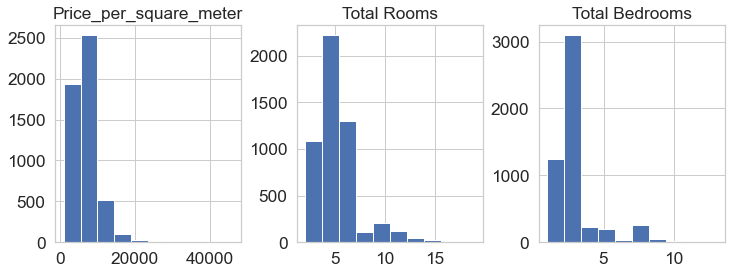

In [35]:
housing_train.hist(column=['Price_per_square_meter', 'Total Rooms', 'Total Bedrooms'], figsize=(12,4),layout=(1,3));

In [36]:
min_y= -23.8
max_y= -23.2
min_x= -46.95
max_x= -46

housing_train[ (housing_train['Latitude'] < min_y )   |
         (housing_train['Longitude'] < min_x )  |
         (housing_train['Latitude']  > max_y )  |
         (housing_train['Longitude'] > max_x )  ].shape

(380, 17)

## 🚩 2. Create a Function to imput na values


## 🚩 3. Create a Custom Tranformer


## 🚩 4. Build a Pipeline 

## 🏁 5. Create a column transform

